In [27]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import sklearn
import ast
import validators
import string
import demoji
# import pyLDAvis.sklearn

from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

In [28]:
df = pd.read_csv('translated_dataframe.csv')
df.head()

,id,conversation_id,created_at,date,time,user_id,tweet,language,hashtags,reply_to,translated_text,tokenized_text
0,1598103832080584704,1598103832080584704,2022-12-01 07:56:59 Malay Peninsula Standard Time,2022-12-01,07:56:59,1582818998324178944,Twitterのフォロワーを増やしたい。最低でも1万人。 #ChatGPT https:/...,ja,['chatgpt'],[],I want to increase my Twitter followers. At le...,"['I', 'want', 'to', 'increase', 'my', 'Twitter..."
1,1598103601507102720,1598103597388279808,2022-12-01 07:56:04 Malay Peninsula Standard Time,2022-12-01,07:56:04,1454189325432901640,"Overall, using AI to create art can expand the...",en,['chatgpt'],[],"Overall, using AI to create art can expand the...","['Overall', ',', 'using', 'AI', 'to', 'create'..."
2,1598103593634369536,1598103593634369536,2022-12-01 07:56:02 Malay Peninsula Standard Time,2022-12-01,07:56:02,118166119,Este prompt fue creado con #ChatGPT el nuevo m...,es,"['chatgpt', 'martesdedatos', 'chatgpt']",[],This prompt was created with #ChatGPT the new ...,"['This', 'prompt', 'was', 'created', 'with', '..."
3,1598103115060084736,1598103115060084736,2022-12-01 07:54:08 Malay Peninsula Standard Time,2022-12-01,07:54:08,141730376,Just played around with OpenAI's new #ChatGPT ...,en,"['chatgpt', 'embodiedcarbon', 'poetry']",[],Just played around with OpenAI's new #ChatGPT ...,"['Just', 'played', 'around', 'with', ""OpenAI's..."
4,1598102468243599361,1598102468243599360,2022-12-01 07:51:34 Malay Peninsula Standard Time,2022-12-01,07:51:34,4034337795,I asked #ChatGPT to write me a story about Sov...,en,['chatgpt'],[],I asked #ChatGPT to write me a story about Sov...,"['I', 'asked', '#ChatGPT', 'to', 'write', 'me'..."


In [29]:
# Extracting a single column
chatgpt_docs = df['tokenized_text']

In [30]:
def DFToDocument(df):
    document = []
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    for i, row in df.iterrows():
        sentence = ""
        tokenized_text = ast.literal_eval(row['tokenized_text'])
        for token in tokenized_text:
            if token not in stop_words and not validators.url(token) and token not in string.punctuation:
                sentence += token + ' '
        sentence = demoji.replace_with_desc(string = sentence, sep = ":")
        document.append(sentence[:-1])
    return document

In [31]:
chatgpt_docs_joined = DFToDocument(df)

In [32]:
print(chatgpt_docs_joined)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [33]:
# CountVectorizer converts the text documents to a matrix of token counts
vectorizer = CountVectorizer()
chatgpt_vecs = vectorizer.fit_transform(chatgpt_docs_joined)

# get_feature_names saves all the words. This allows us to see the words in each topic later
feature_names = vectorizer.get_feature_names_out()

In [34]:
# Build LDA Model
chatgpt_lda = LatentDirichletAllocation(
                batch_size=128, doc_topic_prior=None,
                evaluate_every=-1, learning_decay=0.7,
                learning_method='online', learning_offset=10.0,
                max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
                n_components=10, perp_tol=0.1,
                random_state=100, topic_word_prior=None,
                total_samples=1000000.0, verbose=0) 
# n_jobs = -1
# use all available CPU
lda_output = chatgpt_lda.fit_transform(chatgpt_vecs)

# NOTE:
# Changed in version 0.19: n_topics was renamed to n_components

In [35]:
print(chatgpt_lda.get_params())

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [36]:
# EXTRA: Diagnosing the model with log-likelihood
# Log-likelihood: the higher the better

print("Log Likelihood: ", chatgpt_lda.score(chatgpt_vecs))

Log Likelihood:  -4417362.120050223


In [37]:
# write a function to display the 10 topics and for each topic we choose the top most frequent words. 
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 15
display_topics(chatgpt_lda, feature_names, 15)

Topic 0:
chatgpt ai google could things tools great money marketing thread internet saying bard talking power
Topic 1:
chatgpt give makes knowledge uses sweat ways answers program ever cybersecurity python car blockchain metaverse
Topic 2:
chatgpt asked write come love japan found quite story copy poem bit mr understanding woman
Topic 3:
chatgpt take level don self fire high industry chinese business 24 wanted bitcoin btc group
Topic 4:
chatgpt gpt chat ai get ask time bing like using one we answer can use
Topic 5:
chatgpt it use also like think good know want right would make if write information
Topic 6:
chatgpt ai people openai the technology artificialintelligence chatbot how seems us via tech try new
Topic 7:
face with chatgpt the smiling of eyes on joy tears here thinking rolling robot grinning
Topic 8:
chatgpt that go midjourney different put tone art there skin another 20 lol jobs old
Topic 9:
chatgpt ai you the better intelligence artificial world gpt openai gpt4 week new next

In [38]:
#Set up the environment to display the graphical outputs
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [39]:
# Generate the visuals
visual = pyLDAvis.sklearn.prepare(chatgpt_lda, chatgpt_vecs, vectorizer, mds='tsne')

/home/jupyter/.local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [40]:
#Save the output|to the html file
pyLDAvis.save_html(visual, "topic_viz_sklearn_more.html")

In [41]:
# Compute Perplexity - Lower the better. 
# Perplexity = exp(-1. * log-likelihood per word)

print("Perplexity: ", chatgpt_lda.perplexity(chatgpt_vecs))

Perplexity:  4385.895590352163


# GridSearch for the best LDA model

In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 
                 'learning_decay': [0.5, 0.7, 0.9]}

# Init the Model
# chatgpt_lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(chatgpt_lda, param_grid=search_params, n_jobs=8)

# Do the Grid Search
model.fit(chatgpt_vecs)

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 random_state=100),
             n_jobs=8,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [44]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(chatgpt_vecs))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -1055157.9339771334
Model Perplexity:  4165.3377128866805


In [45]:
import matplotlib.pyplot as plt

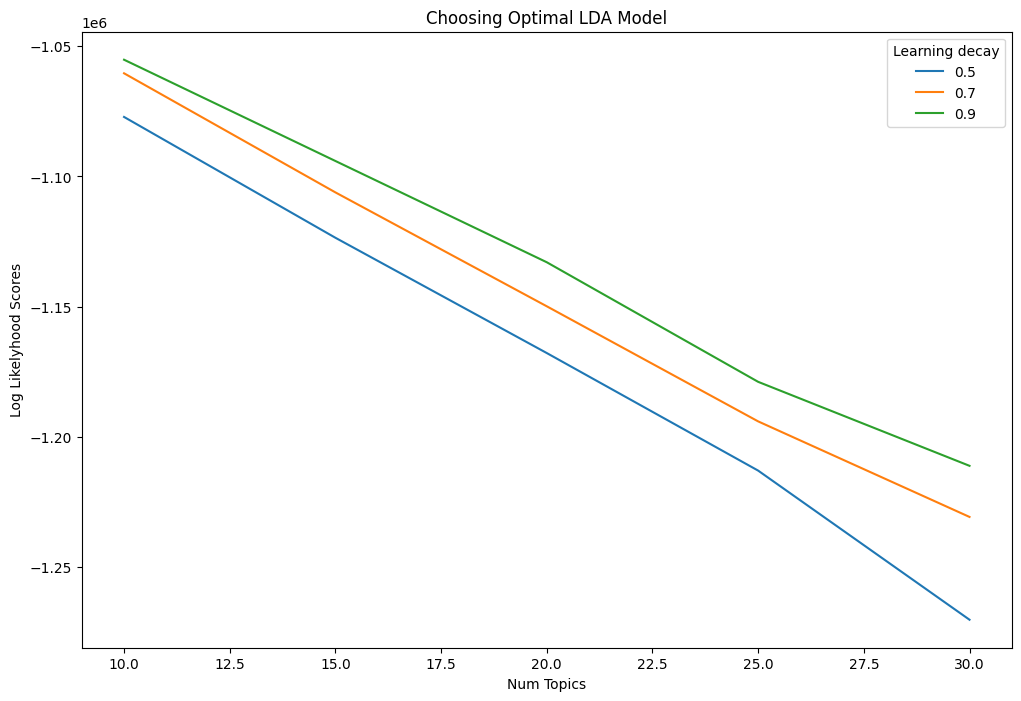

In [46]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]

log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]


# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [47]:
# I ASSUME THIS IS THE END OF GRID SEARCH

In [ ]:
# Can take a long time to run. In this case we are going to k_max=14.
import datetime
print(datetime.datetime.now())

from gensim.models import CoherenceModel

model_list = []
perplexity_values = []
model_topics = []

for num_topics in range(2, 14, 2):
    chatgpt_lda_x = LatentDirichletAllocation(n_components=num_topics, learning_method='online')
#     , n_jobs = -1
    chatgpt_lda_x.fit_transform(chatgpt_vecs)
    model_topics.append(num_topics)
    model_list.append(chatgpt_lda_x)
    perplexity_values.append(chatgpt_lda_x.perplexity(chatgpt_vecs))
    print("#Topics: " + str(num_topics) + ", Score: " + str(chatgpt_lda_x.perplexity(chatgpt_vecs)))

print(datetime.datetime.now())

In [ ]:
# Show graph

import matplotlib.pyplot as plt

limit=14; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [ ]:
# Create Document - Topic Matrix
#I choose model_list[2] where the number of topics is 6
lda_output = model_list[2].transform(chatgpt_vecs)

# column names
topicnames = ["Topic" + str(i) for i in range(model_list[2].n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(chatgpt_docs))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 5), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
num_doc_to_show = 10  # change this to display the number of documents shown below
df_document_topics = df_document_topic.head(num_doc_to_show).style.applymap(color_green).applymap(make_bold)
df_document_topics

In [ ]:
import joblib
#Save a model to disk, or reload a pre-trained model

chatgpt_lda=model_list[1]
joblib.dump(chatgpt_lda, 'chatgpt_lda.jl')

# # then reload it with
lda_disk = joblib.load('chatgpt_lda.jl')

In [ ]:
# SAVING THE LDA MODEL

In [ ]:
#Code to save theta
import pandas as pd

df_document_topic.to_csv("doc_topic_with_gridsearch.csv")

In [ ]:
# Write code here to save top 10 words for each topic (beta)
top_words_per_topic = []
    
for topic_idx, topic in enumerate(chatgpt_lda.components_):
    topic_word_P = [(topic_idx, feature_names[i], topic[i]) for i in topic.argsort()[:-no_top_words - 1:-1]]
    top_words_per_topic.extend(topic_word_P)

pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_words_with_gridsearch.csv")

In [ ]:
# END OF SKLEARN LDA